In [2]:
import pandas as pd
import tensorflow as tf
import torch

from utils.fnSampling import get_random_sample_directory
# Setting pandas display option
pd.set_option("display.max_colwidth", None)

print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Is cuda available: {torch.cuda.is_available()}")
print(f"Tensorflow: {tf.__version__}")

# Time stratified random sample of 1% of the 4chan dataset - used as unlabeled data
sampled_rows = get_random_sample_directory('data/datasets/TSRS/', 0.01)
# Custom training dataset created from a time stratified sample of 4chan dataset - used to train the classifer
spam_dataset = pd.read_parquet('./data/datasets/baselines/4chan/spam_dataset.parquet')
# Baseline training dataset - used to train the classifer
SMS_dataset = pd.read_csv('./data/datasets/baselines/SMS/SMSSpamCollection_cleaned.csv')

Num GPUs Available: 1
Is cuda available: True
Tensorflow: 2.13.0


#### Step 1: Dialog Detection with Grid Search
- **Sample Size and Threshold Ranges**: Define a parameter grid to determine values for `sample_size` and `similarity_threshold`.
- **Grid Search**: Apply a grid search to evaluate the dialog detector's performance over different parameters using a custom DialogDetector class that employs techniques like BERT embeddings and cosine similarity.
- **Plotting**: Visualize how the proportion of dialog varies with different thresholds.
- **Finding the Knee/Elbow in the Curve**: Determine the optimal threshold for a significant drop-off in spam proportion.
- **DialogDetector Class**: A class containing methods for dialog detection leveraging various textual analysis methods.
- **apply_detector Function**: A function that applies the DialogDetector to given data using specified parameters to label each text as spam or not.

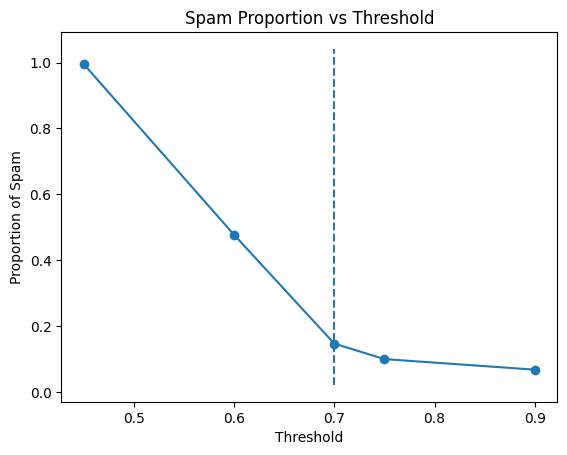

Optimal threshold for significant drop-off: 0.7
spam_label
NOT_SPAM    0.719804
            0.144595
SPAM        0.135601
Name: proportion, dtype: float64


In [7]:
import logging
import pandas as pd
from utils import fnSampling 
from utils import fnTesting
from srcs.labeler import DialogDetector, apply_detector

# Configure logging
logging.basicConfig(level=logging.INFO)
# Note: The following datasets were sourced using Power Analysis with Alpha 0.05, Power 0.8, Effect 0.01
# Time stratified sampling was performed by hour
# The reasoning for these specific parameters can be found in README.md and SPT.ipynb markdown cells
# Examples are named using the suffix that details its properties (Alpha 0.05, Power 0.8, Effect 0.01)

# Get a random set that was pulled using the Power Analysis
sample_random_A05P8E01 = fnSampling.get_processed_sample('./data/datasets/TSRS/')

# Copy dataframe loaded above and run threshold analysis
data = sample_random_A05P8E01.copy()  
params = {
    'sample_size': [len(data))],
    'similarity_threshold': [0.45,0.6,0.7,0.75,0.9]
}
optimal_threshold, results , summary_table = fnTesting.evaluate_spam_threshold(data, params)
# Perform clustering and visualize the results
spam_ratio, dialog_data, similarity_training_data, spam_detector = apply_detector(data, optimal_threshold, int(len(data)/4))
print(spam_ratio)

Example interpretation of the above breakdown: 
- **NOT_SPAM: 71.98%**: The proportion classified as not spam.
- **Unlabeled: 14.46%**: The proportion of the sample that is not classified as either spam or not spam. This unlabeled segment is then passed to the UTA algorithm for classification.
- **SPAM: 13.56%**: The proportion classified as spam.

#### Step 2: Text Analysis using a Five-Number Summary Attention Score Method
- **Document Embedding**: Utilize BERT's attention scores and apply a custom five-number summary method to them, capturing essential characteristics of the text data.
- **Clustering and Visualization**: Cluster documents using KMeans, visualize clusters, and calculate the ratio of junk/spam within each cluster.
- **Further Classification**: Identify clusters with a specific spam ratio and filter the data, allowing more refined categorization.

These steps encompass the core functionalities for text analysis, uniquely integrating attention scores from BERT to provide insightful understanding into the text data. The approach combines sophisticated techniques like deep learning embeddings, clustering, and statistical summaries, enhancing the analysis and categorization of the text data.

cluster
0     0.014563
1     0.018957
2     0.000000
3     1.000000
4     0.000000
5     0.153153
6     1.000000
7     0.510638
8     0.033333
9     0.000000
10    0.007519
11    0.000000
12    0.026906
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
Name: spam_label, dtype: float64


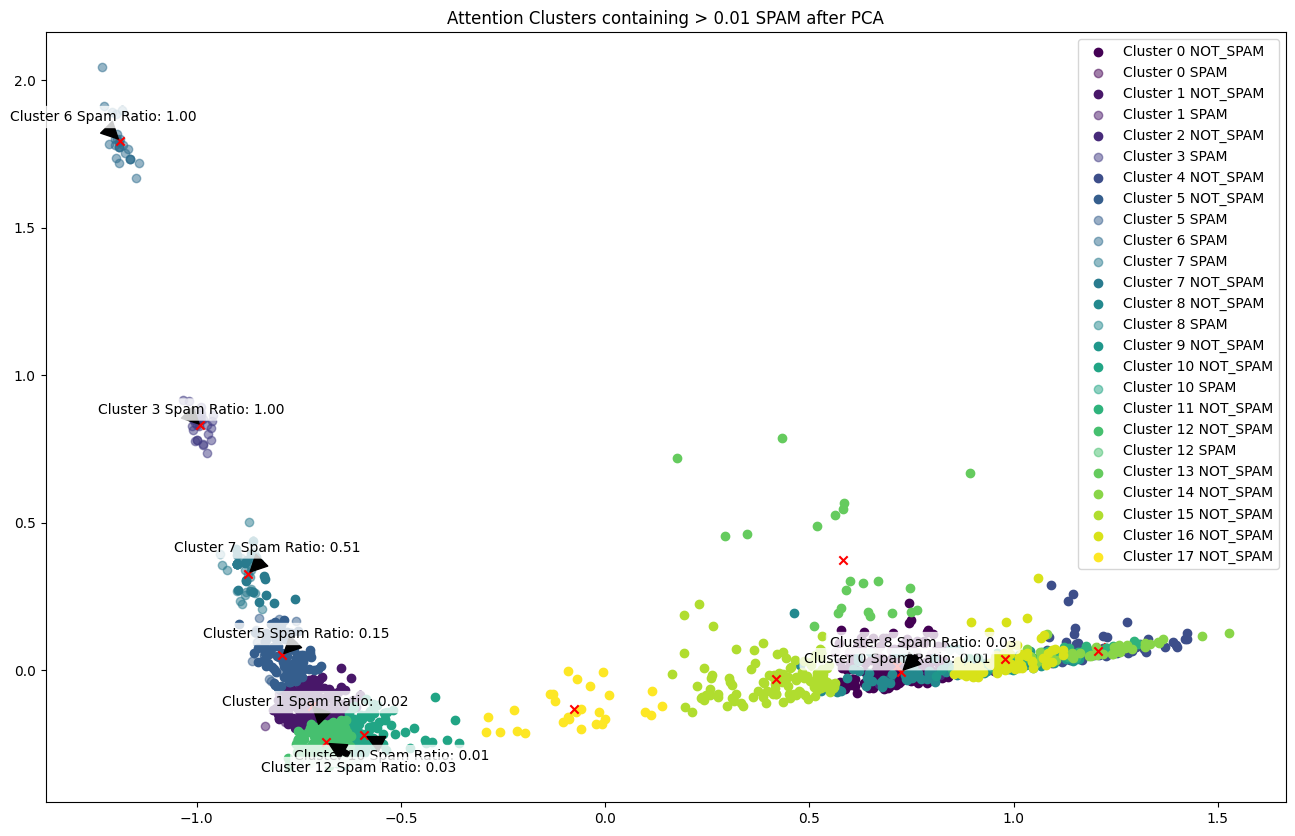

In [7]:
from srcs import attention_filter

fig, cluster_junk_ratio, data_clustered = attention_filter.main_plotting(dialog_data.sample(1500), max_length=512, show_scatter=True)

# Identify clusters with a specific spam ratio and filter the data for further classification
spam_clusters = cluster_junk_ratio[cluster_junk_ratio > 0.01].index.tolist()
certanty_data = data_clustered[~data_clustered['cluster'].isin(spam_clusters) & ~data_clustered['spam_label'].isin([''])]

#### Step 3: Training and Preparing the Classifier
- **Model and Tokenizer Initialization**: Load the pre-trained BERT model and corresponding tokenizer, with attention outputs enabled.
- **Parameter Definition**: Set various hyperparameters for training, including the number of epochs, batch size, layers, dropout rate, regularization, learning rate, and decay parameters.
- **Data Loading and Preprocessing**: Load and process the training, validation, and testing datasets. The data is vectorized using the method provided in `classifier.load_and_process_data`.
- **Label Encoding**: Use LabelEncoder to fit and transform the labels into an encoded format, making them suitable for training the model.
- **TensorFlow Dataset Conversion**: Convert the numpy arrays for training, validation, and testing data into TensorFlow datasets.
- **Batching**: Batch the datasets according to the defined batch size.
- **Model Training**: Train the model using the classifier's `train_model` function with the processed training data and validation data, following the specified parameters.
- **Uncertainty-aware Self-training**: Using `self_train` to apply the UST method by iteratively training a teacher model on labeled data, generating pseudo-labels on unlabeled data, and training a student model on the pseudo-labeled data. Utilize variance in predictions as a proxy for uncertainty and sample pseudo-labels using Bayesian Active Learning by Disagreement (BALD). Continuously improve the pseudo-labels across iterations to enhance the model’s performance.

In [28]:
# The following code prepares the training data for the classification task and trains the model. The model is stored for use in the proceeding uncertainty estimation task.
import numpy as np
from srcs.classifier import classifier
from srcs.classifier import load_classifier
from srcs.classifier import UST_trainer
from utils.fnPlots import plot_history
from sklearn.preprocessing import LabelEncoder
from transformers import BertModel, BertTokenizer

params = {
    'epochs': 10,
    'batch_size': 5,
    'layers': [32,32,32],
    'dropout': 0.1,
    'batch_normalization': True,
    'l1_reg': 0.0015,
    'l2_reg': 0.0015,
    'initial_learning_rate': 0.00125,
    'decay_steps': 10000,
    'decay_rate': 0.96,
    'T': 10
}
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name, output_attentions=True)

tokenizer = BertTokenizer.from_pretrained(model_name)

# Load and process the training data
data_path = './data/datasets/baselines/4chan/splits'
load_classifier.load_and_split_data_smote(spam_dataset, 'spam_label', output_folder=data_path)
# Process new data
data_dict, max_length = classifier.load_and_process_data(data_path)
train_data = np.stack(data_dict['train']['vector'].values)
val_data = np.stack(data_dict['val']['vector'].values)
test_data = np.stack(data_dict['test']['vector'].values)
train_labels = data_dict['train']['spam_label'].values
val_labels = data_dict['val']['spam_label'].values
test_labels = data_dict['test']['spam_label'].values
# Initialize the encoder
encoder = LabelEncoder()
# Fit the encoder and transform the labels
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

# Convert the numpy arrays into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
train_dataset = train_dataset.batch(params['batch_size'])
val_dataset = val_dataset.batch(params['batch_size'])
test_dataset = test_dataset.batch(params['batch_size'])

# Define the spam clusters and classifier object as needed
history, original_model = classifier.train_model(train_data, train_labels, val_data, val_labels, params)
# Run UST on the clustered data. Remember that this data has can be assumed to be confidently labeled after going through similarity threshold method and clustering. The classifer will now predict the label to improve the overall performance of the model. 
data_clustered['spam_label'] = ''
final_model, evaluation_metrics, final_histories = UST_trainer.self_train(train_data, train_labels, val_data, val_labels, data_clustered, params, spam_clusters, classifier)

Epoch 1/10
7/9 [======================>.......] - ETA: 0s - loss: 2.3879 - accuracy: 0.7679 INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 2s 124ms/step - loss: 2.3226 - accuracy: 0.7970 - val_loss: 2.3230 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 2/10
8/9 [=========================>....] - ETA: 0s - loss: 1.8819 - accuracy: 0.8984INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 106ms/step - loss: 1.8818 - accuracy: 0.8947 - val_loss: 2.0461 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 3/10
8/9 [=========================>....] - ETA: 0s - loss: 1.6375 - accuracy: 0.9023INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 149ms/step - loss: 1.6270 - accuracy: 0.9060 - val_loss: 1.8123 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 4/10
7/9 [======================>.......] - ETA: 0s - loss: 1.4511 - accuracy: 0.9018INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 107ms/step - loss: 1.4314 - accuracy: 0.9023 - val_loss: 1.6145 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 5/10
8/9 [=========================>....] - ETA: 0s - loss: 1.2211 - accuracy: 0.9219INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 104ms/step - loss: 1.2116 - accuracy: 0.9248 - val_loss: 1.4466 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 6/10
6/9 [===================>..........] - ETA: 0s - loss: 1.1447 - accuracy: 0.8958INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 106ms/step - loss: 1.1190 - accuracy: 0.8985 - val_loss: 1.3139 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 7/10
8/9 [=========================>....] - ETA: 0s - loss: 0.9627 - accuracy: 0.9258INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 106ms/step - loss: 0.9663 - accuracy: 0.9211 - val_loss: 1.2068 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 8/10
8/9 [=========================>....] - ETA: 0s - loss: 0.9071 - accuracy: 0.9023INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 144ms/step - loss: 0.8983 - accuracy: 0.9060 - val_loss: 1.1274 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 9/10
8/9 [=========================>....] - ETA: 0s - loss: 0.8056 - accuracy: 0.9219INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 107ms/step - loss: 0.8169 - accuracy: 0.9211 - val_loss: 1.0852 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 10/10
8/9 [=========================>....] - ETA: 0s - loss: 0.7803 - accuracy: 0.9219INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 106ms/step - loss: 0.7898 - accuracy: 0.9173 - val_loss: 1.0620 - val_accuracy: 0.8644 - lr: 0.0012
Epoch 1/10
8/9 [=========================>....] - ETA: 0s - loss: 2.2243 - accuracy: 0.8516 INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 3s 161ms/step - loss: 2.2292 - accuracy: 0.8459 - val_loss: 2.3618 - val_accuracy: 0.3898 - lr: 0.0012
Epoch 2/10
8/9 [=========================>....] - ETA: 0s - loss: 1.9023 - accuracy: 0.8789INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 112ms/step - loss: 1.8928 - accuracy: 0.8835 - val_loss: 2.0994 - val_accuracy: 0.8305 - lr: 0.0012
Epoch 3/10
8/9 [=========================>....] - ETA: 0s - loss: 1.6123 - accuracy: 0.9023INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 107ms/step - loss: 1.6099 - accuracy: 0.8985 - val_loss: 1.8676 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 4/10
7/9 [======================>.......] - ETA: 0s - loss: 1.4009 - accuracy: 0.9241INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 109ms/step - loss: 1.4114 - accuracy: 0.9098 - val_loss: 1.6759 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 5/10
8/9 [=========================>....] - ETA: 0s - loss: 1.2140 - accuracy: 0.9102INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 107ms/step - loss: 1.2122 - accuracy: 0.9060 - val_loss: 1.5073 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 6/10
8/9 [=========================>....] - ETA: 0s - loss: 1.0607 - accuracy: 0.9258INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 108ms/step - loss: 1.0554 - accuracy: 0.9286 - val_loss: 1.3631 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 7/10
8/9 [=========================>....] - ETA: 0s - loss: 0.9723 - accuracy: 0.9062INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 151ms/step - loss: 0.9670 - accuracy: 0.9098 - val_loss: 1.2582 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 8/10
8/9 [=========================>....] - ETA: 0s - loss: 0.8482 - accuracy: 0.9258INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 110ms/step - loss: 0.8553 - accuracy: 0.9248 - val_loss: 1.1812 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 9/10
8/9 [=========================>....] - ETA: 0s - loss: 0.8268 - accuracy: 0.9062INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 108ms/step - loss: 0.8307 - accuracy: 0.9060 - val_loss: 1.1287 - val_accuracy: 0.7458 - lr: 0.0012
Epoch 10/10
8/9 [=========================>....] - ETA: 0s - loss: 0.7782 - accuracy: 0.9258INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


INFO:tensorflow:Assets written to: saved_models/best_model.tf/assets


9/9 [==============================] - 1s 106ms/step - loss: 0.7725 - accuracy: 0.9286 - val_loss: 1.1049 - val_accuracy: 0.7458 - lr: 0.0012
INFO:tensorflow:Assets written to: saved_models/student_model_0.tf/assets


INFO:tensorflow:Assets written to: saved_models/student_model_0.tf/assets


47/47 [==============================] - 0s 2ms/step


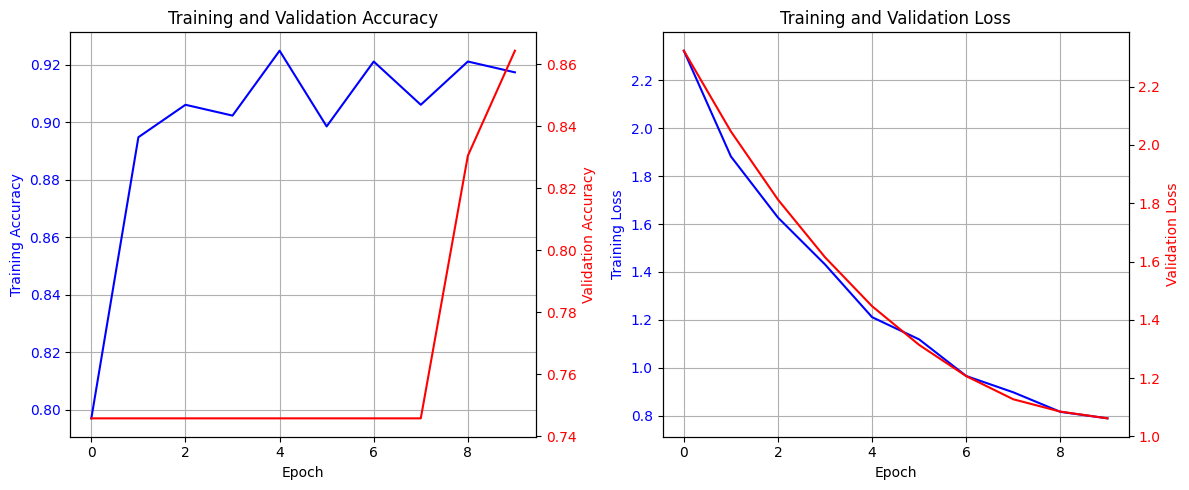

2/2 [==============================] - 0s 7ms/step - loss: 1.0301 - accuracy: 0.8644
Test Loss: 1.0301213264465332
Test Accuracy: 0.8644067645072937
1/1 [==============================] - 0s 52ms/step
Sample Labels: [1 1 1 0 1 1 1 1 1 0]
Sample Predictions: [[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [29]:
plot_history(history)
# Evaluate on test set
test_loss, test_acc = original_model.evaluate(test_data, test_labels, verbose=1)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Sample predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]
sample_predictions = original_model.predict(sample_data)
sample_predictions = (sample_predictions > 0.5).astype(int) # Thresholding
print('Sample Labels:', sample_labels)
print('Sample Predictions:', sample_predictions)

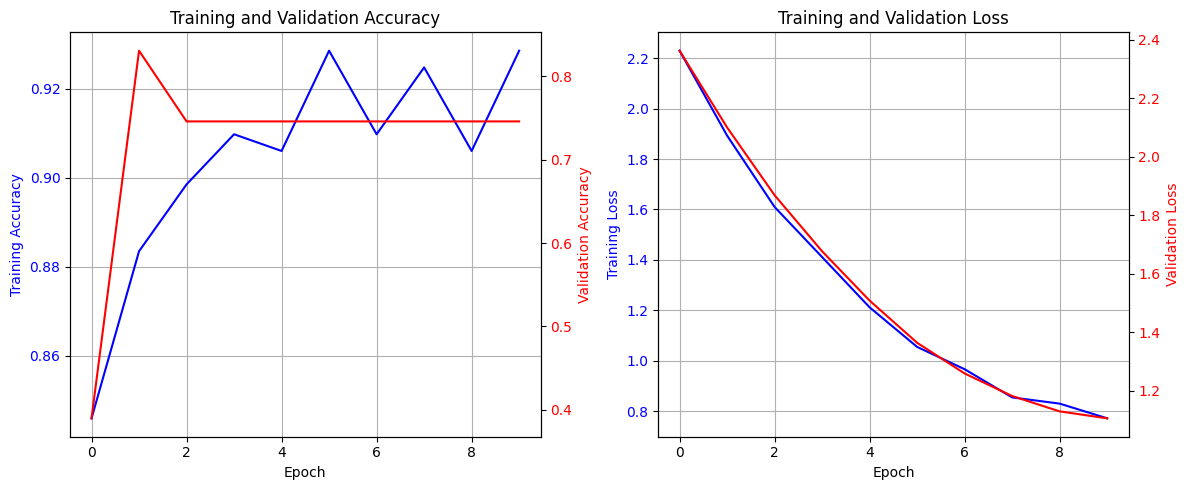

2/2 - 0s - loss: 0.7458 - accuracy: 0.8983 - 22ms/epoch - 11ms/step
Test Loss: 0.7457742691040039
Test Accuracy: 0.8983050584793091
1/1 [==============================] - 0s 418ms/step
Sample Labels: [1 1 1 0 1 1 1 1 1 0]
Sample Predictions: [[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [30]:
plot_history(final_histories[-1]) # Use the appropriate history object for final model
# Evaluate on test set
test_loss, test_acc = final_model.evaluate(test_data, test_labels, verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Sample predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]
sample_predictions = final_model.predict(sample_data)
sample_predictions = (sample_predictions > 0.5).astype(int) # Thresholding
print('Sample Labels:', sample_labels)
print('Sample Predictions:', sample_predictions)


UST looks to have increased model performance on the custom dataset. Specifically, the validation accuracy increased from 0.8644 to 0.8983